In [1]:
import pickle
from string import punctuation

import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
# Load the data
import logging
logger = logging.getLogger("spacy")
logger.setLevel(logging.ERROR)

import dask.bag as db
import json

docs = db.read_text('../Data/arxiv-metadata-oai-snapshot.json').map(json.loads)

In [ ]:
# Trimming the data
get_latest_version = lambda x: x['versions'][-1]['created']


# get only necessary fields of the metadata file
trim = lambda x: {'id': x['id'],
                  'authors': x['authors'],
                  'title': x['title'],
                  'versions': x['versions'],
                  'category':x['categories'].split(' '),
                  'abstract':x['abstract'],}

# filter for papers published on or after 2019-01-01
columns = ['id','category','abstract','versions']
docs_df = docs.map(trim).compute()

# convert to pandas
docs_df = pd.DataFrame(docs_df)

In [ ]:
#save trimmed dataset for later use so we can skip the dataset trimming later:
docs_df.to_csv("../Data/trimmed_arxiv_docs2.csv", index=False)

In [3]:
# Read docs from the file
docs_df = pd.read_csv('../Data/trimmed_arxiv_docs2.csv')

/Users/miamijovic/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
# Listing categories
categories = list(docs_df['category'].unique())

In [5]:
# Split categories
def splitCategory(cat):
    tmp = cat.replace('[','').replace(']','')
    c = tmp.split(', ')
    c = [w.replace("'","") for w in c]
    return c

In [6]:
# Find main category
def findMainCat(categories):
    new_cat = list(dict.fromkeys([cat.split(".")[0] for cat in categories]))
    return new_cat


Cleaning the data

In [7]:
df = pd.read_csv("../Data/trimmed_arxiv_docs2.csv")

In [8]:
# Adding abstract word count
df['abstract_word_count'] = docs_df['abstract'].apply(lambda x: len(x.strip().split())) 

In [9]:
df['abstract'].describe(include='all')

count                                1967621
unique                               1965958
top         This paper has been withdrawn.\n
freq                                      91
Name: abstract, dtype: object

In [10]:
# Getting rid of duplicates
df.drop_duplicates(['abstract',], inplace=True)
df['abstract'].describe(include='all')

count                                               1965958
unique                                              1965958
top         We propose a theory of chaos for discrete sy...
freq                                                      1
Name: abstract, dtype: object

NLP data processing

In [11]:
# Add the categories
df['list_categories'] = df.category.apply(splitCategory)
df['main_categories'] = df.list_categories.apply(findMainCat)

In [12]:
# Create CS and Random dataframes
bool_series = ["cs" in cat for cat in df.main_categories]
df_cs = df[bool_series]

In [13]:
# Non-CS df
bool_series = ["cs" not in cat for cat in df.main_categories]
df_random = df[bool_series]

In [18]:
# Reduce the size of the data
df_cs = df_cs.sample(100000, random_state=42)
df_random = df_random.sample(100000, random_state=42)

In [19]:
def get_year(version):
    return version.split(': ')[2].split(' ')[3]

In [ ]:
df_cs['year'] = df_cs.versions.apply(get_year)
df_random['year'] = df_random.versions.apply(get_year)

In [21]:
print(sorted(set(df_cs.year)))

['1991', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']


In [22]:
#Define stopwords (scientific stopwords)
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
stopwords = STOP_WORDS

In [23]:
#Define the cleaner - remove punctuation and stopwords
def cleanPunct(text):
    return [w for w in text if w not in punctuation]

In [24]:
# make everything lowercase
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
def low(instance):
    tokens = word_tokenize(instance)
    return [w.lower() for w in tokens if w not in ["(", ")"]]
# Removing stopwords and punctuation
def clean(text):
    return [w for w in text if w not in punctuation and w not in stopwords]
def low2(instance):
    tokens = word_tokenize(instance)
    return [w.lower() for w in tokens if w not in punctuation and w not in stopwords and w not in ["(", ")"]]

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/miamijovic/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [25]:
# Create column with lowercase text
df_cs['cleaned'] = df_cs.abstract.apply(low2)
df_random['cleaned'] = df_random.abstract.apply(low2)


In [26]:
def removeStopwords(text):
    return [w for w in text if w not in stopwords]

In [27]:
#apply cleaning punctiation on unigrams
df_cs['cleaned'] = df_cs.cleaned.apply(removeStopwords)
df_random['cleaned'] = df_random.cleaned.apply(removeStopwords)

In [28]:
df_cs

,id,authors,title,versions,category,abstract,abstract_word_count,list_categories,main_categories,year,cleaned
948505,1802.08965,"Hamid G. Bafghi, Amin Gohari, Mahtab Mirmohsen...",Diffusion Based Molecular Communication with L...,"[{'version': 'v1', 'created': 'Sun, 25 Feb 201...","['cs.IT', 'math.IT']",This paper studies the impact of a transmitt...,160,"[cs.IT, math.IT]","[cs, math]",2018,"[paper, studies, impact, transmitter, molecule..."
1497027,2107.03015,Juan Jose Garau-Luis and Edward Crawley and Br...,Evaluating the progress of Deep Reinforcement ...,"[{'version': 'v1', 'created': 'Wed, 7 Jul 2021...","['cs.LG', 'cs.AI']",Deep Reinforcement Learning (DRL) is conside...,128,"[cs.LG, cs.AI]",[cs],2021,"[deep, reinforcement, learning, drl, considere..."
1040347,1810.0916,"Peter Snyder, Antoine Vastel, Benjamin Livshits",Who Filters the Filters: Understanding the Gro...,"[{'version': 'v1', 'created': 'Mon, 22 Oct 201...",['cs.CR'],Ad and tracking blocking extensions are popu...,275,[cs.CR],[cs],2018,"[ad, tracking, blocking, extensions, popular, ..."
1189193,1910.05274,"Jan H\k{a}z{\l}a, Yan Jin, Elchanan Mossel, Go...",A Geometric Model of Opinion Polarization,"[{'version': 'v1', 'created': 'Fri, 11 Oct 201...","['cs.SI', 'econ.TH']","We introduce a simple, geometric model of op...",103,"[cs.SI, econ.TH]","[cs, econ]",2019,"[introduce, simple, geometric, model, opinion,..."
1336457,2008.08735,"Shuangjun Liu, Xiaofei Huang, Nihang Fu, Cheng...",Simultaneously-Collected Multimodal Lying Pose...,"[{'version': 'v1', 'created': 'Thu, 20 Aug 202...",['cs.CV'],Computer vision (CV) has achieved great succ...,198,[cs.CV],[cs],2020,"[computer, vision, cv, achieved, great, succes..."
...,...,...,...,...,...,...,...,...,...,...,...
1344213,2009.0271,Niloufar Ahmadypour and Amin Gohari,Multi-Way Number Partitioning: an Information-...,"[{'version': 'v1', 'created': 'Sun, 6 Sep 2020...","['cs.DS', 'cs.IT', 'math.CO', 'math.IT']",The number partitioning problem is the probl...,82,"[cs.DS, cs.IT, math.CO, math.IT]","[cs, math]",2020,"[number, partitioning, problem, problem, parti..."
1376344,2011.03596,"Iulia-Cristina Stanica, Florica Moldoveanu, Gi...",Flexible Virtual Reality System for Neurorehab...,"[{'version': 'v1', 'created': 'Fri, 6 Nov 2020...",['cs.GR'],"As life expectancy is mostly increasing, the...",210,[cs.GR],[cs],2020,"[life, expectancy, increasing, incidence, neur..."
809176,1701.03768,Robert Ferens and Marek Szyku{\l}a,Complexity of regular bifix-free languages,"[{'version': 'v1', 'created': 'Fri, 13 Jan 201...",['cs.FL'],We study descriptive complexity properties o...,212,[cs.FL],[cs],2017,"[study, descriptive, complexity, properties, c..."
1488093,2106.10329,"Ryan H. Vogt, N. Anders Petersson",Binary Optimal Control Of Single-Flux-Quantum ...,"[{'version': 'v1', 'created': 'Fri, 18 Jun 202...","['quant-ph', 'cs.NA', 'math.DS', 'math.NA', 'm...","We introduce a binary, relaxed gradient, tru...",147,"[quant-ph, cs.NA, math.DS, math.NA, math.OC]","[quant-ph, cs, math]",2021,"[introduce, binary, relaxed, gradient, trust-r..."


In [35]:
# Make ngrams
from nltk.util import ngrams

def bigrams(arr):
    return list(ngrams(arr, 2))

def trigrams(arr):
    return list(ngrams(arr,3))

In [ ]:
# Creating ngrams
df_cs['bigrams'] = df_cs.cleaned.apply(bigrams)
df_random['bigrams'] = df_random.cleaned.apply(bigrams)
df_cs['trigrams'] = df_cs.cleaned.apply(trigrams)
df_random['trigrams'] = df_random.cleaned.apply(trigrams)


In [31]:
def hyphenate(words, n):
    if(n==2):
        return [w[0]+'-'+w[1] for w in words]
    if(n==3):
        return [w[0]+'-'+w[1]+'-'+w[2] for w in words]

Dictionaties and most frequent term analysis

In [32]:
# Create dict func
def createDict(data):
    vocab = {}
    for instance in data:
        d = Counter(instance)
        for w in d.keys():
            if w in vocab:
                vocab[w] += d[w]
            else:
                vocab[w] = d[w]
    return dict(sorted(vocab.items(), key=lambda item: item[1], reverse=True))

In [51]:
from collections import Counter
uni_cs = createDict(df_cs['cleaned'])
bi_cs = createDict(df_cs['bigrams'])
tri_cs = createDict(df_cs['trigrams'])

uni_rand = createDict(df_random['cleaned'])
bi_rand = createDict(df_random['bigrams'])
tri_rand = createDict(df_random['trigrams'])

In [37]:
print(len(tri_cs))

8144438


In [ ]:
print(list(tri_cs.items())[:1000])

In [45]:
# Trim ngrams 
def trim(d, num):
    return dict((k, v) for k, v in d.items() if v>=num)

In [55]:
trim_value = 20
unigram_cs = trim(uni_cs, trim_value)
unigram_rand = trim(uni_rand, trim_value)
bigram_cs = trim(bi_cs, trim_value)
bigram_rand = trim(bi_rand, trim_value)
trigram_cs = trim(tri_cs, trim_value)
trigram_rand = trim(tri_rand, trim_value)

In [56]:
print(len(trigram_rand))

2545


In [58]:
# Filter out dataframe, leave only ngrams from the list + hyphenate
def filterOutUniCs(words):
    return [w for w in words if w in unigram_cs]
def filterOutBiCs(words):
    return [w[0]+'-'+w[1] for w in words if w in bigram_cs]
def filterOutTriCs(words):
    return [w[0]+'-'+w[1]+'-'+w[2] for w in words if w in trigram_cs]
def filterOutUniRand(words):
    return [w for w in words if w in unigram_rand]
def filterOutBiRand(words):
    return [w[0]+'-'+w[1] for w in words if w in bigram_rand]
def filterOutTriRand(words):
    return [w[0]+'-'+w[1]+'-'+w[2] for w in words if w in trigram_rand]

In [59]:
df_cs.cleaned = df_cs.cleaned.apply(filterOutUniCs)
df_cs.bigrams = df_cs.bigrams.apply(filterOutBiCs)
df_cs.trigrams = df_cs.trigrams.apply(filterOutTriCs)

df_random.cleaned = df_random.cleaned.apply(filterOutUniRand)
df_random.bigrams = df_random.bigrams.apply(filterOutBiRand)
df_random.trigrams = df_random.trigrams.apply(filterOutTriRand)

Feature Selection on CS vs Random

In [60]:
#CHI-Square stastic where:
# a - number of times t and c co-occur 11
# b - number of times t occurs w/o c 10
# c - number of times c occurs w/o t 01
# d - number of times neither c nor t occur 00
def chi_square(n,a,b,c,d):
    return n*((a*d-c*b)**2)/((a+c)*(b+d)*(a+b)*(c+d))

In [61]:
def selectKbest(features, k):
    features = {a: v for a, v in sorted(features.items(), key=lambda item: item[1], reverse=True)}
    features = {a: features[a] for a in list(features)[:k]}
    return features

In [62]:
def findOccurrences(term, C, notC):
    a = 0
    b = 0
    c = 0
    d = 0
    for item in C:
        if term in item:
            a += 1
        else:
            c += 1
    for item in notC:
        if term in item:
            b += 1
        else:
            d += 1
    return a,b,c,d


In [63]:
# Calculate chi2 values for each word
from collections import Counter

def createTermLists(cat, nonCat):
    # Find number of times term and class co-occur
    wordsC = Counter()
    for items in cat:
        wordsC = wordsC + Counter(items)
    return wordsC


In [64]:
def findChiValues(cat, nonCat):
    wordsC = createTermLists(cat, nonCat)
    chi_values = {}
    for term in wordsC:
        a,b,c,d = findOccurrences(term, cat, nonCat)
        n = len(cat) + len(nonCat)
        chi_values[term] = chi_square(n, a, b, c, d)
    return chi_values

In [66]:
chi_values_uni = findChiValues(df_cs.cleaned, df_random.cleaned)

In [67]:
print(len(chi_values_uni))

19028


In [68]:
chi_values_bi = findChiValues(df_cs.bigrams, df_random.bigrams)
chi_values_tri = findChiValues(df_cs.trigrams, df_random.trigrams)

In [69]:
# Filter by chi value chiVal
def selectChiBest(features, chiVal):
    features = {a: v for a, v in sorted(features.items(), key=lambda item: item[1], reverse=True)}
    features = {a: features[a] for a in features if features[a]>chiVal}
    return features

In [70]:
chiVal = 40
chi_best_uni = selectChiBest(chi_values_uni, chiVal)
chi_best_bi = selectChiBest(chi_values_bi, chiVal)
chi_best_tri = selectChiBest(chi_values_tri, chiVal)


In [88]:
import json
chi_vals = [chi_best_uni, chi_best_bi, chi_best_tri]
with open('chi_data.json', 'w') as f:
    json.dump(chi_vals, f)

In [ ]:
# Make unified df
df_combined = df_cs[['abstract', 'list_categories', 'main_categories', 'year']].copy()
#df_tmp = df_random[['abstract', 'list_categories', 'main_categories', 'year']].copy()
#df_combined = df_combined.append(df_tmp)

df_combined

In [72]:
# Filter
def filterAbstract(text, chi_best_bi, chi_best_tri):
    tokens = word_tokenize(text)
    tokens = [w.lower() for w in tokens if w not in punctuation]
    # Find trigrams
    i = 0
    new1 = []
    while(i<len(tokens)-2):
        trigram = tokens[i]+'-'+tokens[i+1]+'-'+tokens[i+2]
        if(trigram in chi_best_tri):
            new1.append(trigram)
            i += 3
        else:
            new1.append(tokens[i])
            i += 1
    
    #Find bigrams
    i = 0
    new2 = []
    while(i<len(new1)-1):
        bigram = new1[i]+'-'+new1[i+1]
        if(bigram in chi_best_bi):
            new2.append(bigram)
            i += 2
        else:
            new2.append(new1[i])
            i += 1

    return new2


In [73]:
df_combined['filteredAbstracts'] = df_combined.abstract.apply(filterAbstract, chi_best_bi = chi_best_bi, chi_best_tri = chi_best_tri)

In [74]:
print(list(df_combined.filteredAbstracts.head(3)))

[['this', 'paper-studies', 'the', 'impact', 'of', 'a', 'transmitter', "'s", 'molecule', 'generation-process', 'on', 'the', 'capacity', 'of', 'a', 'concentration', 'based', 'molecular-communication', 'mc', 'system', 'constraints', 'caused', 'by', 'the', 'molecule', 'generation-process', 'affect', 'the', 'availability', 'of', 'the', 'molecules', 'at', 'the', 'transmitter', 'the', 'transmitter', 'has', 'a', 'storage', 'of', 'molecules', 'and', 'should', 'decide', 'whether', 'to', 'release', 'or', 'save', 'the', 'currently', 'produced', 'molecules', 'as', 'a', 'result', 'the', 'mc', 'system', 'has', 'conceptual', 'connections', 'with', 'energy-harvesting', 'systems', 'in', 'this', 'paper', 'we', 'consider', 'two', 'scenarios', 'on', 'the', 'propagation', 'channel', 'the', 'first', 'scenario', 'assumes', 'a', 'channel', 'with', 'no', 'inter-symbol', 'interference', 'isi', '\\emph', 'i.e.', 'a', 'memoryless-channel', 'we', 'derive', 'bounds', 'on', 'the', 'capacity', 'of', 'the', 'mc', 'syst

In [75]:
def filterAdvance(text):
    return [w for w in text if (w in chi_best_uni or w in chi_best_bi or w in chi_best_tri) and w in dictCombined and len(w)>1]

In [76]:
# Remove stop words
df_combined['filteredAbstracts'] = df_combined.filteredAbstracts.apply(clean)

In [ ]:
dictCombined = createDict(df_combined['filteredAbstracts'])
trim_value = 20
dictCombined = trim(dictCombined, trim_value)
print(dictCombined)

In [78]:
# Filter out unigrams as well
df_combined['doubleFilteredAbstracts'] = df_combined.filteredAbstracts.apply(filterAdvance)

In [79]:
print(list(df_combined.doubleFilteredAbstracts.head(1)))

[['paper-studies', 'impact', 'transmitter', 'molecule', 'generation-process', 'capacity', 'concentration', 'based', 'molecular-communication', 'system', 'constraints', 'molecule', 'generation-process', 'affect', 'availability', 'molecules', 'transmitter', 'transmitter', 'storage', 'molecules', 'decide', 'save', 'currently', 'produced', 'molecules', 'result', 'system', 'conceptual', 'connections', 'energy-harvesting', 'systems', 'paper', 'consider', 'scenarios', 'channel', 'assumes', 'channel', 'interference', 'isi', '\\emph', 'i.e.', 'derive', 'bounds', 'capacity', 'system', 'second', 'assumes', 'network', 'isi', 'output', 'channel', 'depends', 'released', 'molecules', 'previous', 'time-slots', 'based', 'assumptions', 'transmitter', 'receiver', 'knows', 'channel-statistics', 'lower-bound']]


In [80]:
# Make a list of unified abstracts
abstracts = []
for item in df_combined.doubleFilteredAbstracts:
    abstracts.extend(item)

In [81]:
abstractDict = Counter(abstracts)
abstractDict = trim(abstractDict, 7)
len(abstractDict)

15470

In [82]:
import itertools
with open('abstractDict.json', 'w') as f:
    json.dump(abstractDict, f)

In [83]:
import itertools
with open('abstracts.txt', 'w') as f:
    f.write(str(abstracts))

In [84]:
abstracts2 = []
for item in df_combined.filteredAbstracts:
    abstracts2.extend(item)

In [85]:
corpus = " ".join(abstracts2)
with open('../glove/merged_abstracts.txt', 'w') as f:
    f.write(corpus)

In [86]:
y_sub = []
for x in df_combined.list_categories:
    for elem in x:
        if(elem.split('.')[0]=='cs'):
            y_sub.append(elem)
            break

In [238]:
df_combined

,abstract,list_categories,main_categories,year,filteredAbstracts,doubleFilteredAbstracts,topic_hits,topics
0,This paper studies the impact of a transmitt...,"['cs.IT', 'math.IT']","['cs', 'math']",2018,"[paper-studies, impact, transmitter, molecu...","[paper-studies, impact, transmitter, molecu...",{3: 1},(3)
1,Deep Reinforcement Learning (DRL) is conside...,"['cs.LG', 'cs.AI']",['cs'],2021,"[deep-reinforcement-learning, drl, considere...","[deep-reinforcement-learning, drl, potential...",{39: 1},(39)
2,Ad and tracking blocking extensions are popu...,['cs.CR'],['cs'],2018,"[ad, tracking, blocking, extensions, popul...","[ad, tracking, blocking, popular, tools, ...",{26: 1},(26)
3,"We introduce a simple, geometric model of op...","['cs.SI', 'econ.TH']","['cs', 'econ']",2019,"[introduce, simple, geometric, model, opin...","[introduce, simple, model, opinion, polari...",{15: 1},(15)
4,Computer vision (CV) has achieved great succ...,['cs.CV'],['cs'],2020,"[computer-vision, cv, achieved-great-success...","[computer-vision, achieved-great-success, se...",{22: 1},(22)
...,...,...,...,...,...,...,...,...
99995,The number partitioning problem is the probl...,"['cs.DS', 'cs.IT', 'math.CO', 'math.IT']","['cs', 'math']",2020,"[number, partitioning, problem, problem, p...","[number, partitioning, problem, problem, p...",{20: 1},(20)
99996,"As life expectancy is mostly increasing, the...",['cs.GR'],['cs'],2020,"[life, expectancy, increasing, incidence, ...","[life, increasing, incidence, neurological,...",{38: 1},(38)
99997,We study descriptive complexity properties o...,['cs.FL'],['cs'],2017,"[study, descriptive, complexity, properties...","[study, descriptive, complexity, properties...",{15: 1},(15)
99998,"We introduce a binary, relaxed gradient, tru...","['quant-ph', 'cs.NA', 'math.DS', 'math.NA', 'm...","['quant-ph', 'cs', 'math']",2021,"[introduce, binary, relaxed, gradient, tru...","[introduce, binary, gradient, trust-region,...",{15: 1},(15)


GLoVe Embeddings

In [14]:
import json
chi_values_list = []
with open('chi_data.json') as f:
    for jsonObj in f:
        chi_values_dict = json.loads(jsonObj)
        chi_values_list.append(chi_values_dict)

In [15]:
chi_values_list = chi_values_list[0]

In [184]:
len(chi_values_list[0])

8159

In [17]:
import numpy as np
vectors_path = '../glove/vectors.txt' # Change this to the relative path on your machine

def load_glove_model(File):
    glove_model = {}
    with open(File,'r') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array(split_line[1:], dtype=np.float64)
            glove_model[word] = embedding
    print(f"{len(glove_model)} words loaded!")
    return glove_model

vectors = load_glove_model(vectors_path)
print(vectors['paper'])

54885 words loaded!
[-0.178835  1.214547 -0.525743  0.217757  0.111511 -0.568359  0.02135
  0.215346  0.034275  1.405665  0.668409  1.081121 -0.062614  0.512672
  1.74567   0.294345 -0.603375  1.214255 -0.686911  1.769573 -0.059688
 -1.816329  0.991589  0.642701  0.092342 -0.558925 -0.349652  0.858243
  0.36422  -1.331225  0.612227  0.442673 -0.072671  0.739846 -1.027029
 -1.319507 -0.916538 -0.281523 -0.604788 -0.224496  0.403863  0.490132
  0.029132 -0.399059  0.004445  0.396464  0.307495 -1.128836 -0.72205
  0.528067]


In [18]:
print(vectors['paper'].shape)

(50,)


In [19]:
def createVectors(all_terms, vectors):
    termDict = {}
    for term in all_terms:
        try:
            termDict[term] = vectors[term]
        except:
            print(term)
    return termDict

In [20]:
def vec2term(vector, vectors):
    for vec in vectors:
        if vec.value().all == vector:
            return vec.key()
    return "NO MATCH"

In [185]:
with open('./abstractDict.json') as f:
    abstractDict = json.load(f)

In [186]:
termDict = createVectors(abstractDict.keys(), vectors)

In [187]:
len(termDict)

15470

Clustering

In [188]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from scipy.spatial.distance import cdist
from sklearn import metrics

In [334]:
k = 40
kmeans = KMeans(n_clusters=k, random_state=42)

np_vectors= list(termDict.values())

In [335]:
import math
for i in range(len(np_vectors)):
    if(np.isnan(np.sum(np_vectors[i]))):
        np_vectors[i] = [0]*50
        

In [285]:
#PCA reduction
from sklearn.decomposition import PCA
pca = PCA(n_components=20)

pca.fit(np_vectors)

PCA(n_components=20)

In [336]:
def kMeansPredict(np_vector):
    return kmeans.fit_predict(np_vector)

y_pred= kMeansPredict(np_vectors)

Visualisation

In [337]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=0, perplexity=50, n_iter=1000, random_state=0)
tsne_results = tsne.fit_transform(np_vectors)


/Users/miamijovic/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

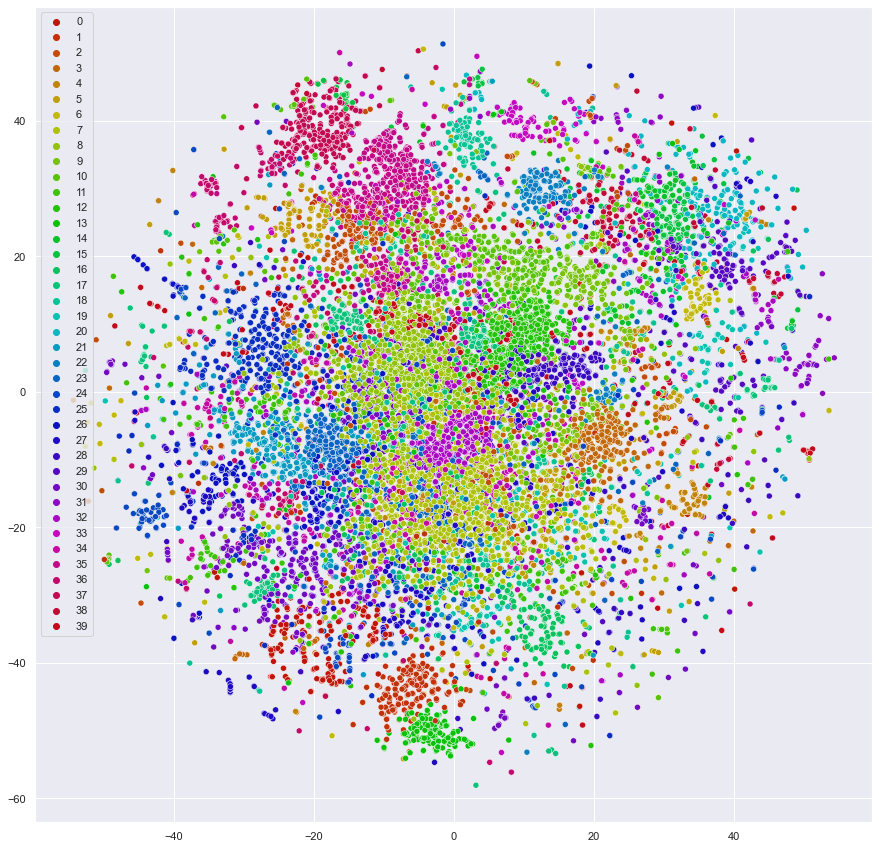

In [338]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(15,15)})

palette = sns.hls_palette(k, l=.4, s=.9)

sns.scatterplot(tsne_results[:,0], tsne_results[:,1], hue=y_pred, palette=palette, legend='full')

In [339]:
#Find nearest neighbours of a term
from scipy.spatial import distance
def findNearestNeighbour(term, vectors):
    term_vec = vectors[term]
    tmp = {k: v for k,v in sorted(vectors.items(), key=lambda item: distance.cosine(term_vec, item[1]))}
    nearest = list({k: tmp[k] for k in list(tmp)[:10]}.keys())

    return nearest



In [196]:
for center in kmeans.cluster_centers_:
    for k,v in vectors.items():
        if(v.all == center.all):
            print(k)

In [340]:
def findNearestNeighbourVec(term_vec, vectors):
    tmp = {k: v for k,v in sorted(vectors.items(), key=lambda item: distance.cosine(term_vec, item[1]))}
    nearest = list({k: tmp[k] for k in list(tmp)[:10]}.keys())

    return nearest

In [198]:
centers = kmeans.cluster_centers_
n = findNearestNeighbourVec(centers[0], vectors)
labels = list(range(len(centers)))
neighbourTerms2 = pd.DataFrame({0:n})
for i in range(len(centers)):
    n = findNearestNeighbourVec(centers[i], vectors)
    #print(i,n)
    neighbourTerms2[i] = n

neighbourTerms2

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,mimo,uqe,accountability,quadratic-programming,attacks,0.49,semantics,ericsson,problem-different,contentious,...,ec-assisted,devices,remember,upper-bounds,copd,better-accuracy,rgb+d,confirm,research,learning-to-rank
1,multi-user,adatd,communication-efficiency,solving-convex,image-scaling,per-letter,logical,leaflets,rgb-based,address-key,...,ar/vr,application,model-learn,lower-bounds,thermo-mechanical,on-par,math23k,experiment-results,aspects,unsupervised-learning
2,communication-system,psec-td,transparency,markov-decision,attack,mse,syntax,transversely,matched-filtering,thorny,...,gps-enabled,infrastructure,blockgan,tight-lower,disease,superior-accuracy,ntu,validate,important,semisupervised
3,downlink,\sigma^\infty,certain-level,vehicle-routing,code-reuse,wsr,logic,diplomatic,problems-existing,shortcoming,...,logchain,enabling,educate,bound,ckd,outperforms-competitive,sketchy,experimental-evaluations,understanding,learning-methods
4,multiple-input-multiple-output-mimo,\leqslant,improving-model,vrp,type-flaw,slnr,multipreference,right-hand-side,approaches-usually,presents-significant,...,e-health,deployment,identify-important,bounds,recounting,competitive-performance-compared,gtzan,experimental-evaluation,focus,learning-reinforcement-learning
5,multi-antenna,t_max,security-privacy,nonlinear-optimization,flush+reload,paoi,ocwa,non-static,dictionary-based,tackling,...,eol,mobile,meaningfully,tight,chronic,competitive-accuracy,dtu,real-world-datasets,developing,semi-supervised-learning
6,multiuser,\varphi_,durability,combinatorial-optimization-problem,blackhole,nrmse,abstract,ana,nlp-based,data-imbalance,...,adhoc,support,features-directly,constant-factor,chd,significant-performance-improvement,clevr,extensive-simulations,development,supervised-learning
7,single-user,maximin-share,compromising,resulting-optimization,known-plaintext,lcr,programs,inter-category,sbi,overcoming,...,femtocellular,applications,enables-users,upper-bound,activist,superior-performance-compared,voxceleb1,extensive-experimental-results,perspective,supervised
8,relay,=\mathbb,efficiency-effectiveness,eld,malicious,end-to-end-delay,formal,k-modes,geometric-based,faced,...,smart-home,enable,subvert,lower-bound,obstructive,astounding,inbreast,experimental-results-validate,work,morl
9,channels,2+1,data-privacy,pde-constrained,defend,equivocation,if-then,trajectory-level,steganalyzers,computational-challenges,...,infrastructures,capabilities,safely,near-optimal,diseases,state-of-the-art-classification,sail,comprehensive-experiments,related,semi-supervised


In [341]:
zip_iterator = zip(termDict.keys(), y_pred)

value_clusters = dict(zip_iterator)

In [342]:
clusters = {}
for term in value_clusters.items():
    clusters[term[1]] = []
for term in value_clusters.items():
    clusters[term[1]].append(term[0])

In [ ]:
for i in clusters.keys():
    print(i,clusters[i])

In [344]:
print(clusters[15])

['based', 'system', 'systems', 'paper', 'consider', 'scenarios', 'network', 'previous', 'framework', 'improve', 'real-world', 'multiple', 'test', 'models', 'work', 'focus', 'different', 'finally', 'tracking', 'popular', 'improving', 'performance', 'use', 'variety', 'apply', 'improves', 'applying', 'provide', 'application', 'propose', 'allow', 'applied', 'introduce', 'simple', 'model', 'demonstrate', 'idea', 'computational', 'algorithms', 'tasks', 'settings', 'furthermore', 'datasets', 'task', 'dataset', 'including', 'present', 'strategy', 'generation', 'fully', 'design', 'state-of-the-art', 'trained', 'effectively', 'data', 'improved', 'study', 'achieved', 'fast', 'algorithm', 'control', 'approach', 'optimization', 'steps', 'achieve', 'demonstrated', 'problem', 'step', 'recent', 'results', 'wide-range', 'learning', 'networks', 'compared', 'complex', 'experiments', 'comparing', 'proposed', 'specifically', 'classical', 'benchmark', 'promising', 'create', 'end-to-end', 'studied', 'solutio

Number of hits per topic

In [345]:
#Number of word from certain cluster in the abstract
from collections import Counter

def topicHits(text, value_clusters):
    topics = {}
    wordDict = Counter(text)
    for word in wordDict.keys():
        if(word in value_clusters.keys()):
            topics[value_clusters[word]] = wordDict[word]
    return topics

In [346]:
#Just return which topics were hit
def pureTopics(topics):
    return topics.keys()

In [249]:
df_combined = pd.read_csv('../Data/df_combined.csv')

In [347]:
def makeList(text):
    tmp = text.split(',')
    for i in range(len(tmp)):
        tmp[i] = tmp[i].replace('[','')
        tmp[i] = tmp[i].replace("'",'')
        tmp[i] = tmp[i].replace(']','')
        tmp[i] = tmp[i].replace(" ",'')
    return tmp

In [250]:
df_combined.doubleFilteredAbstracts = df_combined.doubleFilteredAbstracts.apply(makeList)

In [251]:
df_combined.filteredAbstracts = df_combined.filteredAbstracts.apply(makeList)

In [252]:
df_combined

,abstract,list_categories,main_categories,year,filteredAbstracts,doubleFilteredAbstracts,topic_hits,topics
0,This paper studies the impact of a transmitt...,"['cs.IT', 'math.IT']","['cs', 'math']",2018,"[paper-studies, impact, transmitter, molecule,...","[paper-studies, impact, transmitter, molecule,...","{25: 1, 21: 1, 24: 1, 5: 1, 2: 1, 3: 1, 26: 1,...","dict_keys([25, 21, 24, 5, 2, 3, 26, 16, 15, 23..."
1,Deep Reinforcement Learning (DRL) is conside...,"['cs.LG', 'cs.AI']",['cs'],2021,"[deep-reinforcement-learning, drl, considered,...","[deep-reinforcement-learning, drl, potential, ...","{20: 3, 26: 1, 14: 1, 8: 1, 1: 1, 22: 1, 21: 1...","dict_keys([20, 26, 14, 8, 1, 22, 21, 7, 2, 9, ..."
2,Ad and tracking blocking extensions are popu...,['cs.CR'],['cs'],2018,"[ad, tracking, blocking, extensions, popular, ...","[ad, tracking, blocking, popular, tools, impro...","{29: 1, 26: 1, 7: 1, 21: 1, 1: 1, 0: 1, 16: 1,...","dict_keys([29, 26, 7, 21, 1, 0, 16, 22, 5, 8, ..."
3,"We introduce a simple, geometric model of op...","['cs.SI', 'econ.TH']","['cs', 'econ']",2019,"[introduce, simple, geometric, model, opinion,...","[introduce, simple, model, opinion, polarizati...","{26: 1, 29: 1, 11: 3, 1: 1, 16: 1, 21: 1, 25: ...","dict_keys([26, 29, 11, 1, 16, 21, 25, 7, 2, 15..."
4,Computer vision (CV) has achieved great succ...,['cs.CV'],['cs'],2020,"[computer-vision, cv, achieved-great-success, ...","[computer-vision, achieved-great-success, sema...","{8: 1, 1: 1, 12: 1, 26: 1, 7: 1, 14: 1, 16: 1,...","dict_keys([8, 1, 12, 26, 7, 14, 16, 23, 4, 29,..."
...,...,...,...,...,...,...,...,...
99995,The number partitioning problem is the probl...,"['cs.DS', 'cs.IT', 'math.CO', 'math.IT']","['cs', 'math']",2020,"[number, partitioning, problem, problem, parti...","[number, partitioning, problem, problem, parti...","{16: 1, 22: 1, 26: 1, 12: 1, 3: 1, 18: 1, 1: 2...","dict_keys([16, 22, 26, 12, 3, 18, 1, 19, 6])"
99996,"As life expectancy is mostly increasing, the...",['cs.GR'],['cs'],2020,"[life, expectancy, increasing, incidence, neur...","[life, increasing, incidence, neurological, di...","{29: 1, 26: 1, 10: 1, 7: 1, 2: 2, 8: 1, 16: 1,...","dict_keys([29, 26, 10, 7, 2, 8, 16, 0, 23, 21,..."
99997,We study descriptive complexity properties o...,['cs.FL'],['cs'],2017,"[study, descriptive, complexity, properties, c...","[study, descriptive, complexity, properties, l...","{26: 1, 15: 1, 16: 1, 18: 1, 1: 3, 21: 3, 3: 2...","dict_keys([26, 15, 16, 18, 1, 21, 3, 5, 11, 12..."
99998,"We introduce a binary, relaxed gradient, tru...","['quant-ph', 'cs.NA', 'math.DS', 'math.NA', 'm...","['quant-ph', 'cs', 'math']",2021,"[introduce, binary, relaxed, gradient, trust-r...","[introduce, binary, gradient, trust-region, me...","{26: 1, 16: 1, 20: 2, 11: 1, 1: 2, 10: 1, 22: ...","dict_keys([26, 16, 20, 11, 1, 10, 22, 25, 6, 1..."


In [237]:
tesf = topicHits(['paper-studies', 'impact', 'transmitter'], value_clusters)

{3: 1, 38: 1, 0: 1}


In [348]:
df_combined['topic_hits'] = df_combined.doubleFilteredAbstracts.apply(topicHits, value_clusters=value_clusters)
df_combined['topics'] = df_combined.topic_hits.apply(pureTopics)
df_combined

,abstract,list_categories,main_categories,year,filteredAbstracts,doubleFilteredAbstracts,topic_hits,topics
0,This paper studies the impact of a transmitt...,"['cs.IT', 'math.IT']","['cs', 'math']",2018,"[paper-studies, impact, transmitter, molecule,...","[paper-studies, impact, transmitter, molecule,...","{3: 1, 38: 1, 0: 1, 16: 2, 7: 2, 20: 1, 33: 1,...","(3, 38, 0, 16, 7, 20, 33, 15, 31, 24, 27, 18, ..."
1,Deep Reinforcement Learning (DRL) is conside...,"['cs.LG', 'cs.AI']",['cs'],2021,"[deep-reinforcement-learning, drl, considered,...","[deep-reinforcement-learning, drl, potential, ...","{39: 3, 38: 1, 15: 1, 30: 1, 22: 1, 29: 1, 14:...","(39, 38, 15, 30, 22, 29, 14, 31, 28, 4, 26, 20)"
2,Ad and tracking blocking extensions are popu...,['cs.CR'],['cs'],2018,"[ad, tracking, blocking, extensions, popular, ...","[ad, tracking, blocking, popular, tools, impro...","{26: 1, 15: 1, 4: 1, 38: 1, 2: 2, 8: 1, 19: 7,...","(26, 15, 4, 38, 2, 8, 19, 27, 20, 31, 14, 34, ..."
3,"We introduce a simple, geometric model of op...","['cs.SI', 'econ.TH']","['cs', 'econ']",2019,"[introduce, simple, geometric, model, opinion,...","[introduce, simple, model, opinion, polarizati...","{15: 1, 27: 1, 34: 1, 26: 1, 29: 1, 38: 1, 20:...","(15, 27, 34, 26, 29, 38, 20, 9, 32, 0)"
4,Computer vision (CV) has achieved great succ...,['cs.CV'],['cs'],2020,"[computer-vision, cv, achieved-great-success, ...","[computer-vision, achieved-great-success, sema...","{22: 1, 29: 1, 6: 1, 15: 1, 34: 1, 31: 1, 20: ...","(22, 29, 6, 15, 34, 31, 20, 14, 9, 25, 38, 4, ..."
...,...,...,...,...,...,...,...,...
99995,The number partitioning problem is the probl...,"['cs.DS', 'cs.IT', 'math.CO', 'math.IT']","['cs', 'math']",2020,"[number, partitioning, problem, problem, parti...","[number, partitioning, problem, problem, parti...","{20: 1, 16: 2, 15: 1, 27: 1, 23: 1, 33: 1, 6: ...","(20, 16, 15, 27, 23, 33, 6, 29, 12, 24, 13)"
99996,"As life expectancy is mostly increasing, the...",['cs.GR'],['cs'],2020,"[life, expectancy, increasing, incidence, neur...","[life, increasing, incidence, neurological, di...","{38: 1, 31: 1, 34: 1, 32: 1, 22: 1, 15: 1, 20:...","(38, 31, 34, 32, 22, 15, 20, 14, 9, 18, 2, 30,..."
99997,We study descriptive complexity properties o...,['cs.FL'],['cs'],2017,"[study, descriptive, complexity, properties, c...","[study, descriptive, complexity, properties, l...","{15: 1, 21: 1, 20: 1, 6: 1, 29: 3, 31: 1, 33: ...","(15, 21, 20, 6, 29, 31, 33, 38, 19, 16, 18, 14..."
99998,"We introduce a binary, relaxed gradient, tru...","['quant-ph', 'cs.NA', 'math.DS', 'math.NA', 'm...","['quant-ph', 'cs', 'math']",2021,"[introduce, binary, relaxed, gradient, trust-r...","[introduce, binary, gradient, trust-region, me...","{15: 1, 20: 1, 28: 2, 11: 6, 19: 1, 31: 1, 24:...","(15, 20, 28, 11, 19, 31, 24, 3, 7, 12, 5, 4, 3..."


In [349]:
# Topic hits per year
hits_per_year = {}
for index, row in df_combined.iterrows():
    if(row['year'] in hits_per_year.keys()):
        hits_per_year[row['year']] = Counter(hits_per_year[row['year']]) + Counter(row['topics'])
    else:
        hits_per_year[row['year']] = Counter(row['topics'])
for key in hits_per_year.keys():
    hits_per_year[key] = {k: v for k, v in sorted(dict(hits_per_year[key]).items(), key=lambda item: item[1], reverse=True)}

hits_per_year

{2018: {15: 10933,
  20: 10797,
  38: 9527,
  29: 9054,
  14: 8750,
  31: 7852,
  37: 5924,
  32: 5552,
  19: 5190,
  35: 5117,
  12: 4895,
  27: 4859,
  8: 4535,
  6: 4534,
  7: 4454,
  23: 4360,
  22: 4255,
  26: 4081,
  39: 4042,
  11: 4026,
  2: 3952,
  33: 3941,
  9: 3925,
  17: 3666,
  4: 3618,
  10: 3592,
  18: 3559,
  5: 3478,
  28: 3389,
  34: 3365,
  30: 3264,
  21: 3108,
  36: 3059,
  25: 3026,
  3: 2846,
  16: 2673,
  24: 2101,
  0: 2047,
  13: 1080,
  1: 888},
 2021: {15: 16559,
  20: 16344,
  38: 14796,
  29: 14094,
  14: 13698,
  31: 12060,
  37: 10000,
  32: 9034,
  35: 8604,
  12: 7945,
  19: 7932,
  8: 7580,
  27: 7491,
  39: 7357,
  23: 7208,
  22: 7195,
  7: 7081,
  2: 6923,
  6: 6871,
  9: 6680,
  11: 6513,
  17: 6466,
  4: 6232,
  26: 6206,
  10: 5945,
  18: 5800,
  34: 5661,
  33: 5515,
  25: 5353,
  5: 5159,
  28: 5118,
  30: 5032,
  36: 5005,
  21: 4825,
  3: 4215,
  16: 3673,
  24: 2877,
  0: 2704,
  13: 1423,
  1: 1132},
 2019: {15: 14289,
  20: 14100,
  38: 

In [350]:
hits_per_year = {k: v for k, v in sorted(hits_per_year.items(), key=lambda item: item[0], reverse=True)}
hits_per_year

{2021: {15: 16559,
  20: 16344,
  38: 14796,
  29: 14094,
  14: 13698,
  31: 12060,
  37: 10000,
  32: 9034,
  35: 8604,
  12: 7945,
  19: 7932,
  8: 7580,
  27: 7491,
  39: 7357,
  23: 7208,
  22: 7195,
  7: 7081,
  2: 6923,
  6: 6871,
  9: 6680,
  11: 6513,
  17: 6466,
  4: 6232,
  26: 6206,
  10: 5945,
  18: 5800,
  34: 5661,
  33: 5515,
  25: 5353,
  5: 5159,
  28: 5118,
  30: 5032,
  36: 5005,
  21: 4825,
  3: 4215,
  16: 3673,
  24: 2877,
  0: 2704,
  13: 1423,
  1: 1132},
 2020: {15: 18396,
  20: 18171,
  38: 16371,
  29: 15557,
  14: 15072,
  31: 13270,
  37: 10917,
  32: 9712,
  35: 9291,
  19: 9119,
  12: 8632,
  27: 8219,
  8: 8094,
  39: 8022,
  23: 7895,
  7: 7841,
  22: 7683,
  6: 7530,
  2: 7434,
  11: 7277,
  9: 7269,
  17: 6931,
  26: 6720,
  4: 6546,
  33: 6540,
  10: 6417,
  18: 6341,
  34: 6240,
  5: 5836,
  28: 5769,
  25: 5733,
  36: 5549,
  30: 5383,
  21: 5277,
  3: 4922,
  16: 4065,
  24: 3223,
  0: 3122,
  13: 1685,
  1: 1351},
 2019: {15: 14289,
  20: 14100,


In [351]:
#Plotting
# 2021: {26: 2100}
# x axis: 2021, y axis: 2100, line: 26
def plottingParams(hits_per_year):
    k = len(set(y_pred))
    min_yr = int(min(set(hits_per_year.keys())))
    max_yr = int(max(set(hits_per_year.keys())))
    yrs = max_yr-min_yr+1
    list_years = list(hits_per_year.keys())
    list_years.reverse()
    x_plotting = np.array(list(range(min_yr, max_yr+1)))
    y_plotting = np.zeros((k,yrs))
    for year in hits_per_year.keys():
        for line in hits_per_year[year].keys():
            y_plotting[line][int(year)-min_yr] = hits_per_year[year][line]
    return x_plotting, y_plotting

In [352]:
x_plotting, y_plotting = plottingParams(hits_per_year)
#print(x_plotting[1])

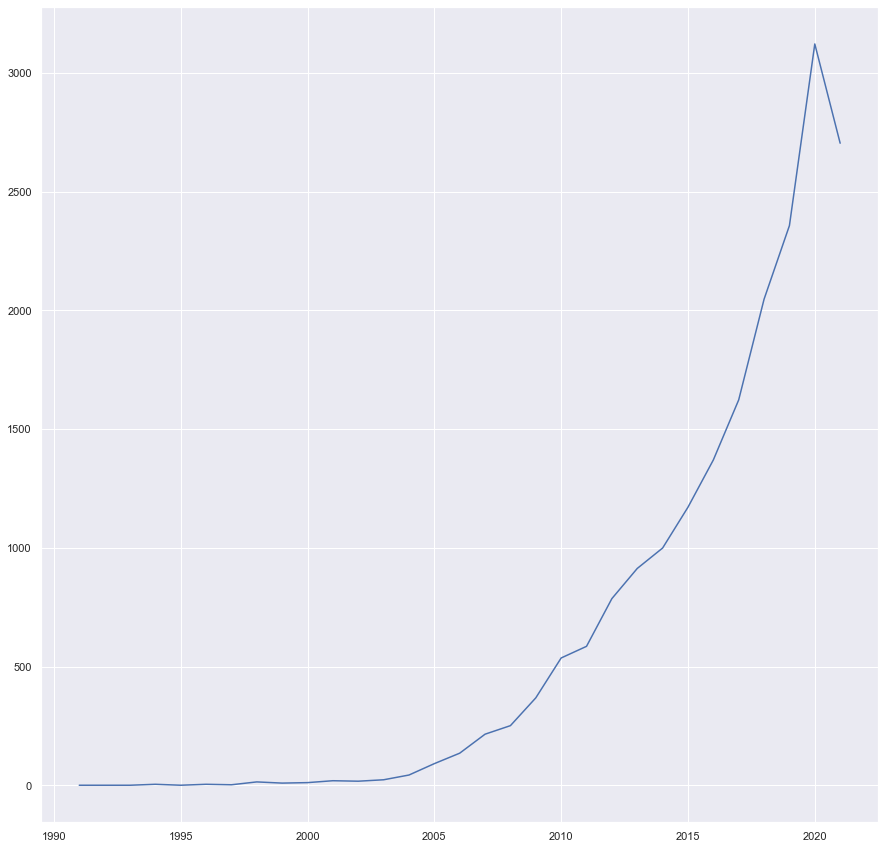

In [353]:
plt.plot(x_plotting, y_plotting[0])

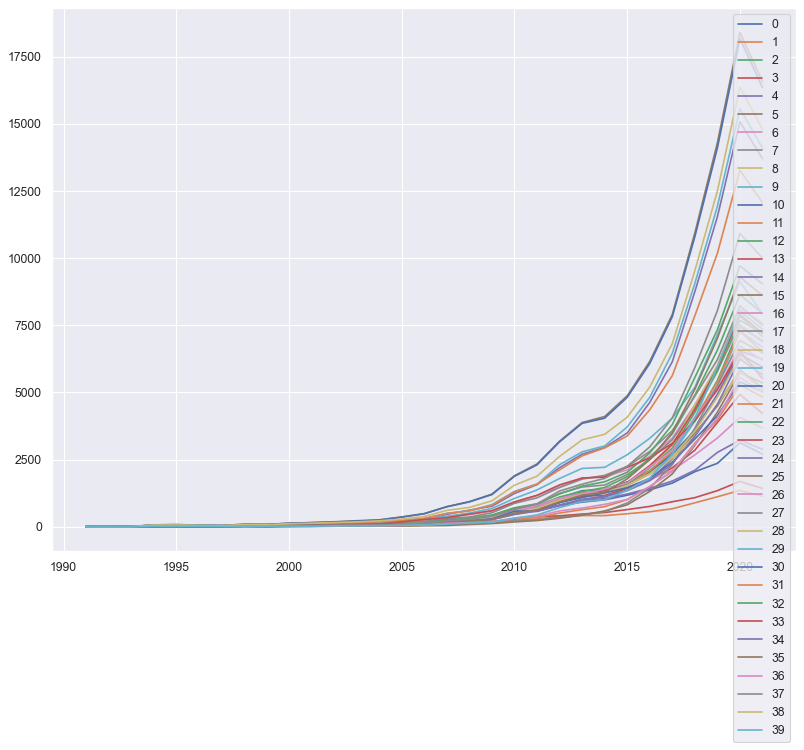

In [354]:
k = len(set(y_pred))
plt.figure(figsize=(12, 9), dpi=80)
for i in range(k):
    plt.plot(x_plotting, y_plotting[i], label=i)
plt.legend()


Normalize topics over time

In [355]:
hits_normalized = {}
for year in hits_per_year.keys():
    total = 0
    hits_normalized[int(year)] = {}
    for key in hits_per_year[year].keys():
        total += hits_per_year[year][key]
    for key in hits_per_year[year].keys():
        hits_normalized[int(year)][key] = hits_per_year[year][key]/total

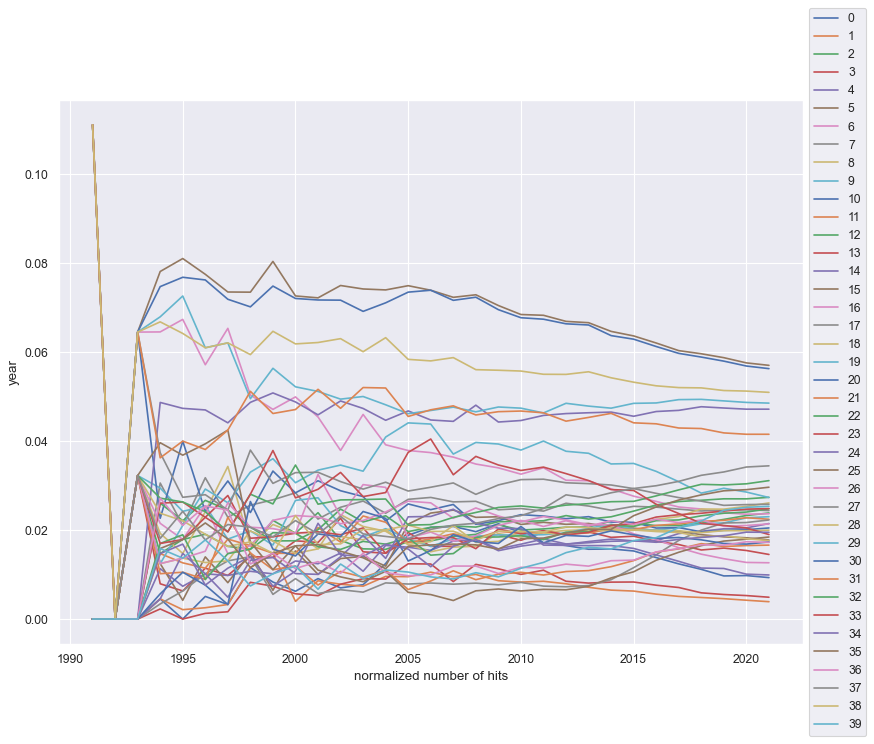

In [356]:
x_p, y_p = plottingParams(hits_normalized)
plt.figure(figsize=(12, 9), dpi=80)
for i in range(k):
    plt.plot(x_p, y_p[i], label=i)
plt.ylabel('year')
plt.xlabel('normalized number of hits')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [262]:
df_combined.to_csv("../Data/df_combined.csv", index=False)

HDBSCAN Clustering

In [379]:
import hdbscan
import sklearn.metrics.pairwise
clusterer = hdbscan.HDBSCAN(min_cluster_size=20, min_samples=1, cluster_selection_method='leaf')
y_hdb = clusterer.fit_predict(np_vectors)


/Users/miamijovic/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

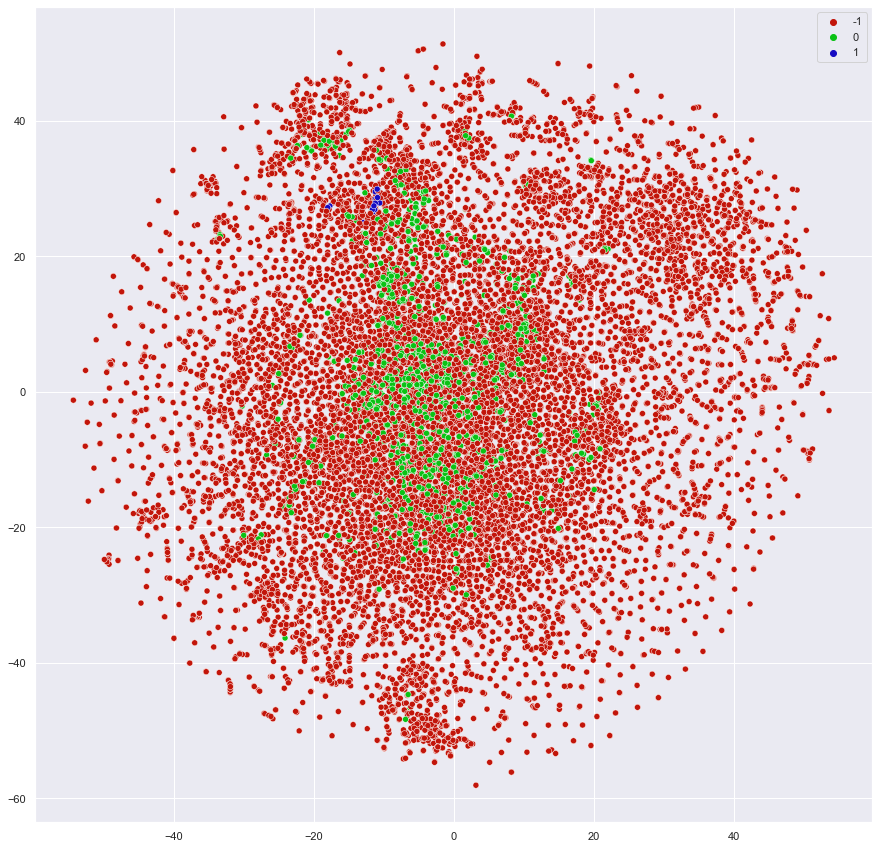

In [380]:
sns.set(rc={'figure.figsize':(15,15)})

palette = sns.hls_palette(len(set(y_hdb)), l=.4, s=.9)

sns.scatterplot(tsne_results[:,0], tsne_results[:,1], hue=y_hdb, palette=palette, legend='full')

In [361]:
zip_iterator2 = zip(termDict.keys(), y_hdb)

value_clusters_hdb = dict(zip_iterator2)

In [362]:
clusters_hdb = {}
for term in value_clusters_hdb.items():
    clusters_hdb[term[1]] = []
for term in value_clusters_hdb.items():
    clusters_hdb[term[1]].append(term[0])

In [366]:
print(clusters_hdb[18])

['allow', 'way', 'facilitate', 'enabling', 'enables', 'enable', 'allowing', 'allows']


DBSCAN Clustering

/Users/miamijovic/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

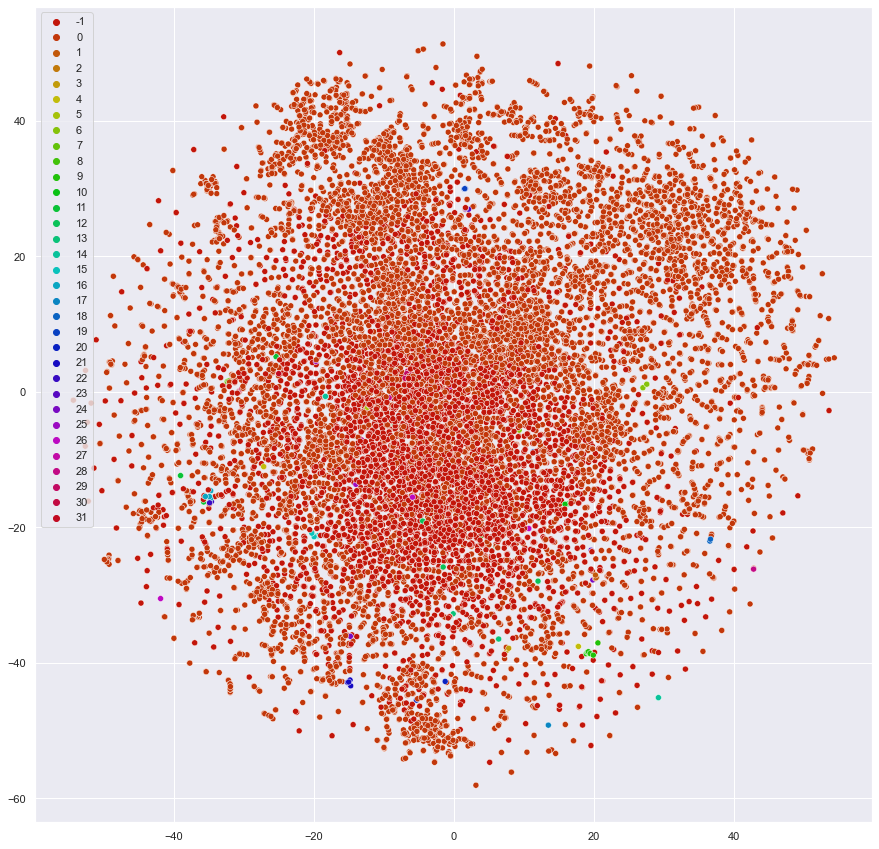

In [391]:
from sklearn.cluster import DBSCAN
db_clusterer = DBSCAN(eps=0.4, metric='cosine')
y_db = db_clusterer.fit_predict(np_vectors)

sns.set(rc={'figure.figsize':(15,15)})

palette = sns.hls_palette(len(set(y_db)), l=.4, s=.9)

sns.scatterplot(tsne_results[:,0], tsne_results[:,1], hue=y_db, palette=palette, legend='full')